In [ ]:
!pip install utils
!pip install Sastrawi
!pip install wordcloud
!pip install matplotlib-venn
# !pip install ax-platform

     |████████████████████████████████| 215kB 8.0MB/s 


In [ ]:
import os
import re
import csv
import nltk
import math
import utils
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from collections import Counter

from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, LSTM, Flatten, Dropout, Activation, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam, Adadelta, Adagrad, Adamax, Ftrl
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


# **Load Data**

In [ ]:
data = pd.read_csv("/gdrive/My Drive/Colab Notebooks/Tugas Akhir/universitas pertamina - ready.csv", sep=",")
# data = pd.read_csv("/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Indonesian Sentiment Twitter Dataset Labeled.csv", sep=",")

In [ ]:
data

,id,date,text,label
0,1.211995e+18,2019-12-31 12:59:10+00:00,Halo Sobat. Ada kabar bahagia nih. Menyambut U...,1
1,1.211976e+18,2019-12-31 11:44:45+00:00,Halo Sobat Muda. Universitas Pertamina melakuk...,1
2,1.211664e+18,2019-12-30 15:02:37+00:00,Kolaborasi adalah kunci. . Terima kasih banyak...,2
3,1.211650e+18,2019-12-30 14:06:05+00:00,"[cm] mau nanya hehe ,buat kaka kaka universita...",1
4,1.211232e+18,2019-12-29 10:24:32+00:00,Universitas Tanjungpura Juarai Pertamina Move ...,2
...,...,...,...,...
4318,7.197797e+17,2016-04-12 06:50:33+00:00,@infoMKS_ utk temen2 yg ingin ikut tryout SBMP...,1
4319,7.197088e+17,2016-04-12 02:08:40+00:00,@UnivPertamina min saya udh daftar dan bayar t...,1
4320,7.194961e+17,2016-04-11 12:03:32+00:00,@UnivPertamina numpang tnya pendaftaran hanya ...,1
4321,7.193715e+17,2016-04-11 03:48:24+00:00,@UnivPertamina :Cara mengambil formulir gimana...,1


# EDA

In [ ]:
plt.figure(figsize = (10,7))
# sns.countplot(x="label", data=data)
sns.countplot(x="sentimen", data=data)

ValueError: ignored

<Figure size 720x504 with 0 Axes>

as we can see the dataset is pretty imbalanced. to compensate that, we'll apply class weights for each of the label

**Panjang karakter tweet**

Min    : 4
Max    : 399
Average: 114.35739070090216


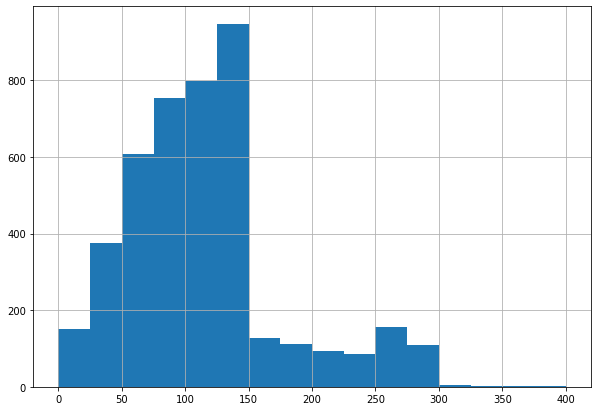

In [ ]:
plt.figure(figsize = (10,7))
length = data['text'].str.len()
length.hist(bins=16, range=[0,400])
print("Min    :", length.min())
# print(data['text'][length[length == length.min()].index[0]])
print("Max    :", length.max())
# print(data['text'][length[length == length.max()].index[0]])
print("Average:", length.mean())

**Jumlah kata per tweet**


Min    : 1
Max    : 52
Average: 16.27295859356928
Sum:  70348


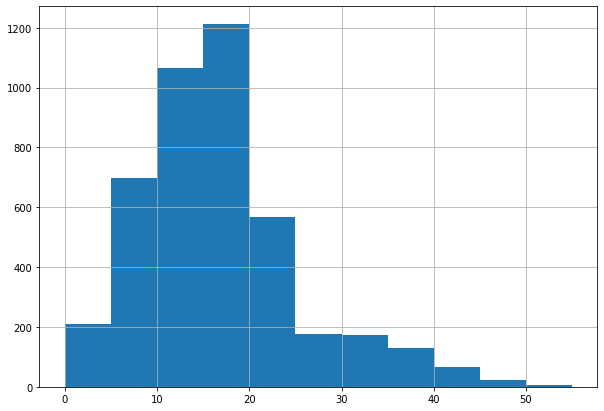

In [ ]:
plt.figure(figsize = (10,7))
num_words = data['text'].str.split().map(lambda x: len(x))
num_words.hist(bins=11, range=[0,55])
print("Min    :", num_words.min())
# print(data['text'][num_words[num_words == num_words.min()].index[0]])
print("Max    :",num_words.max())
# print(data['text'][num_words[num_words == num_words.max()].index[0]])
print("Average:", num_words.mean())
print("Sum: ", num_words.sum())

**Rata - rata jumlah karakter setiap kata di tweet**

Min    : 2.25
Max    : 61.0
Average: 6.207290935285161


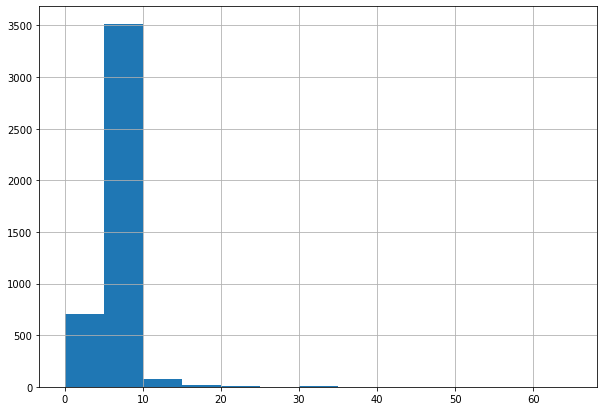

In [ ]:
plt.figure(figsize = (10,7))
avg_length_words = data['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
avg_length_words.hist(bins=13, range=[0,65])
print("Min    :", avg_length_words.min())
print("Max    :", avg_length_words.max())
print("Average:", avg_length_words.mean())

<BarContainer object of 10 artists>

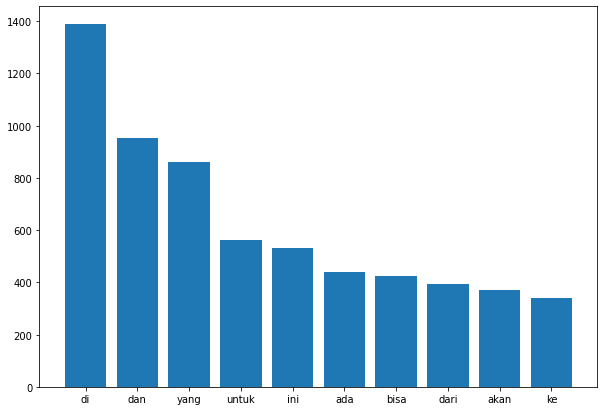

In [ ]:
plt.figure(figsize = (10,7))
corpus=[]
new= data['text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
  if word in stopwords:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

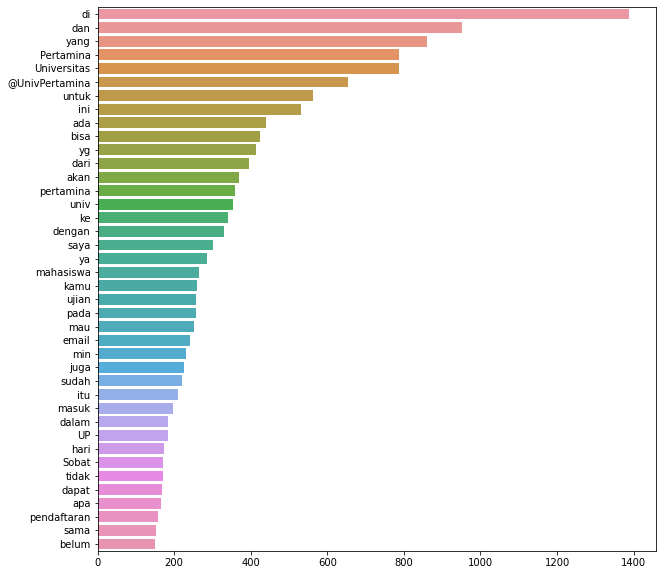

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
plt.figure(figsize = (10,10))
for word,count in most[:40]:
  # if word not in stopwords:
  x.append(word)
  y.append(count)
        
sns.barplot(x=y, y=x)

In [ ]:
df0 = data.loc[data['label'] == 0]
df1 = data.loc[data['label'] == 1]
df2 = data.loc[data['label'] == 2]

# Initializing Dictionary
d0 = {}

# counting number of times each word comes up in list of words (in dictionary)
for sentence in df0["text"]:
  for word in sentence.split(): 
    d0[word] = d0.get(word, 0) + 1

print("kata di negative", len(d0), "jumlah = ", sum(d0.values()))

# Initializing Dictionary
d1 = {}

# counting number of times each word comes up in list of words (in dictionary)
for sentence in df1["text"]:
  for word in sentence.split(): 
    d1[word] = d1.get(word, 0) + 1

print("kata di neutral", len(d1), "jumlah = ", sum(d1.values()))

# Initializing Dictionary
d2 = {}

# counting number of times each word comes up in list of words (in dictionary)
for sentence in df2["text"]:
  for word in sentence.split(): 
    d2[word] = d2.get(word, 0) + 1

print("kata di positive", len(d2), "jumlah = ", sum(d2.values()))

kata di negative 4039 jumlah =  9664
kata di neutral 11257 jumlah =  49649
kata di positive 4217 jumlah =  11035


Kata di negatif dan netral =  752 jumlah =  4462
Kata di negatif dan positive =  111 jumlah =  308
Kata di positive dan netral =  1424 jumlah =  11359
Kata di all =  852 jumlah =  36229
Kata hanya di negative =  2324 jumlah =  2853
Kata hanya di neutral =  8229 jumlah =  13064
Kata hanya di positive =  1830 jumlah =  2073


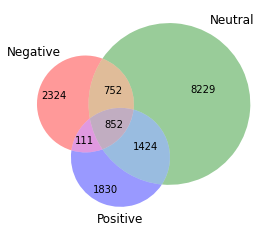

In [ ]:
shared01 = {k: d0[k] + d1[k] for k in d0 if k in d1 and k not in d2}
print("Kata di negatif dan netral = ", len(shared01), "jumlah = ", sum(shared01.values()))

shared02 = {k: d0[k] + d2[k] for k in d0 if k in d2 and k not in d1}
print("Kata di negatif dan positive = ", len(shared02), "jumlah = ", sum(shared02.values()))

shared21 = {k: d2[k] + d1[k] for k in d2 if k in d1 and k not in d0}
print("Kata di positive dan netral = ",len(shared21), "jumlah = ", sum(shared21.values()))

shared_all = {k: d0[k] + d1[k] + d2[k] for k in d0 if k in d1 and k in d2}
print("Kata di all = ",len(shared_all), "jumlah = ", sum(shared_all.values()))

only0 = {k: d0[k] for k in d0 if k not in d1 and k not in d2}
print("Kata hanya di negative = ",len(only0), "jumlah = ", sum(only0.values()))

only1 = {k: d1[k] for k in d1 if k not in d0 and k not in d2}
print("Kata hanya di neutral = ",len(only1), "jumlah = ", sum(only1.values()))

only2 = {k: d2[k] for k in d2 if k not in d0 and k not in d1}
print("Kata hanya di positive = ",len(only2), "jumlah = ", sum(only2.values()))

from matplotlib_venn import venn3
# venn3(subsets = (1, 2, 3, 4, 5, 6, 7), set_labels = ('Set1', 'Set2', 'Set3'))
venn3(subsets = (len(only0), len(only1), len(shared01), len(only2), len(shared02), len(shared21), len(shared_all)), set_labels = ('Negative', 'Neutral', 'Positive'))

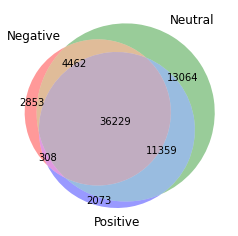

In [ ]:
venn3(subsets = (sum(only0.values()), sum(only1.values()), sum(shared01.values()), sum(only2.values()), sum(shared02.values()), sum(shared21.values()), sum(shared_all.values())), set_labels = ('Negative', 'Neutral', 'Positive'))

# **Preprocessing Data**

In [ ]:
#Load Colloquial indonesian lexicon (kamus alay)

reader = csv.reader(open('/gdrive/My Drive/Colab Notebooks/Tugas Akhir/colloquial-indonesian-lexicon.csv'))

kamus_alay = {}
for row in reader:
  key = row[0]
  if key in kamus_alay:
    # implement your duplicate row handling here
    pass
  kamus_alay[key] = row[1]

factoryStopWord = StopWordRemoverFactory()
stopword = factoryStopWord.create_stop_word_remover()

stemmer = StemmerFactory().create_stemmer()

#preprocess text
def preprocess(text):
  # convert to lowercase
  new_text = text.lower()

  # remove email
  new_text = re.sub(r'(\S)+@(\S)+', ' ', new_text)

  # remove username, hashtag, escape html
  new_text = re.sub(r'[#|@|&][a-zA-Z0-0]* ?', ' ', new_text)
  
  # remove hyperlink
  new_text = re.sub(r'http[s]*[^ ]*', ' ', new_text)
  
  # remove kata ulang
  # new_text = re.sub(r'((\w)+)\s{0,2}-\s{0,2}\1', r'\1', new_text)
  # new_text = re.sub(r'(\w+)\1\d',r'\1', new_text)

  # remove punctuation
  #new_text = re.sub(r'[^\P{P}-]+', '', new_text)
  new_text = re.sub(r'[^\w\s]',' ', new_text)
  
  # remove numbers
  new_text = re.sub(r'\d+','',new_text)

  # # manual steeming
  # new_text = re.sub(r'se(\w+)nya', '\g<1>', new_text)
  # new_text = re.sub(r'(\w+)nya', '\g<1>', new_text)
  # new_text = re.sub(r'di(\w+)in', '\g<1>', new_text)

  # # replace slang language
  pattern = re.compile(r'\b(' + '|'.join(kamus_alay.keys()) + r')\b')
  new_text = pattern.sub(lambda x: kamus_alay[x.group()], new_text)

  # remove universitas or pertamina
  # new_text = re.sub(r'universitas pertamina','',new_text)

  # # stemming
  new_text = stemmer.stem(new_text)
  
  # # remove stopword
  new_text = stopword.remove(new_text)

  # # remove duplicate letter
  # new_text = re.sub(r'([a-z])\1{1,}', r'\1', new_text)
  new_text = re.sub(r'^([a-z])([a-z])(\1|\2)+$', r'\1\2\1\2', new_text)

  # # remove 1-2 letter word
  new_text = re.sub(r'\W*\b\w{1}\b', ' ', new_text)
  
  # remove whitespaces
  new_text = ' '.join(new_text.split())

  return new_text

#preprocess all text and label
def preprocessTrain(text, label):

  clean_data = []
  clean_label = []
  new_text = []
  i = 0

  for x in (text[:]):
    new_text = preprocess(x)
    
    if new_text != '':
      clean_data.append(new_text)
      clean_label.append(label[i])
    
    i = i + 1
  return clean_data, clean_label

# tokennizer
def tokennizing(X, texts, maxlen=30):
  tokenizer = Tokenizer()   
  tokenizer.fit_on_texts(X)

  with open('/gdrive/My Drive/Colab Notebooks/Tugas Akhir/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
  texts = texts.astype(str)
  sequences = tokenizer.texts_to_sequences(texts)
  data = pad_sequences(sequences, maxlen=maxlen)
  
  return data

In [ ]:
data

,id,date,text,label
0,1.211995e+18,2019-12-31 12:59:10+00:00,Halo Sobat. Ada kabar bahagia nih. Menyambut U...,1
1,1.211976e+18,2019-12-31 11:44:45+00:00,Halo Sobat Muda. Universitas Pertamina melakuk...,1
2,1.211664e+18,2019-12-30 15:02:37+00:00,Kolaborasi adalah kunci. . Terima kasih banyak...,2
3,1.211650e+18,2019-12-30 14:06:05+00:00,"[cm] mau nanya hehe ,buat kaka kaka universita...",1
4,1.211232e+18,2019-12-29 10:24:32+00:00,Universitas Tanjungpura Juarai Pertamina Move ...,2
...,...,...,...,...
4318,7.197797e+17,2016-04-12 06:50:33+00:00,@infoMKS_ utk temen2 yg ingin ikut tryout SBMP...,1
4319,7.197088e+17,2016-04-12 02:08:40+00:00,@UnivPertamina min saya udh daftar dan bayar t...,1
4320,7.194961e+17,2016-04-11 12:03:32+00:00,@UnivPertamina numpang tnya pendaftaran hanya ...,1
4321,7.193715e+17,2016-04-11 03:48:24+00:00,@UnivPertamina :Cara mengambil formulir gimana...,1


In [ ]:
X_raw = data['text'].values
y_raw = data['label'].values
# X_raw = data['Tweet'].values
# y_raw = data['sentimen'].values

X_preprocessed, y_preprocessed = preprocessTrain(X_raw, y_raw)

**Drop Duplicate Data**

there's a possibility of tweet from news site that has different link, but same title

In [ ]:
# make a dataframe
dataset = pd.DataFrame({'X': X_preprocessed, 'y': y_preprocessed})

# use dataframe's drop duplicate
dataset_noduplicate = dataset.drop_duplicates()

# assign X and y
X_noduplicate = dataset_noduplicate['X']
y_noduplicate = dataset_noduplicate['y']

In [ ]:
dataset_noduplicate["y"].value_counts()

1    3120
0     634
2     515
Name: y, dtype: int64

# EDA

In [ ]:
plt.figure(figsize = (10,7))
sns.countplot(x="y", data=dataset_noduplicate)
# sns.countplot(x="sentimen", data=data)
# data['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

Min    : 2
Max    : 139
Average: 63.5335491465568


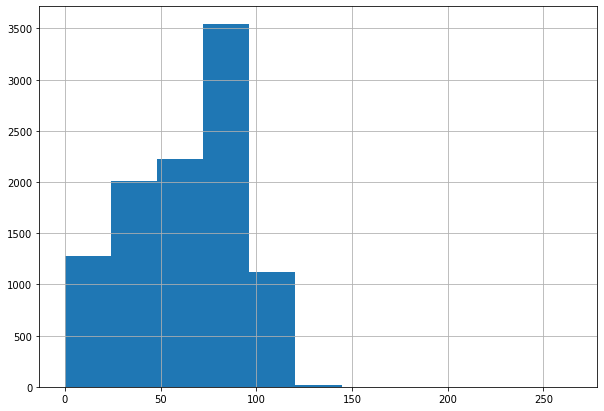

In [ ]:
plt.figure(figsize = (10,7))

length = dataset_noduplicate['X'].str.len()
length.hist(bins=11, range=[0,265])
print("Min    :", length.min())
# print(data['text'][length[length == length.min()].index[0]])
print("Max    :", length.max())
# print(data['text'][length[length == length.max()].index[0]])
print("Average:", length.mean())

Min    : 1
Max    : 43
Average: 12.19606465214336
Sum:  52065


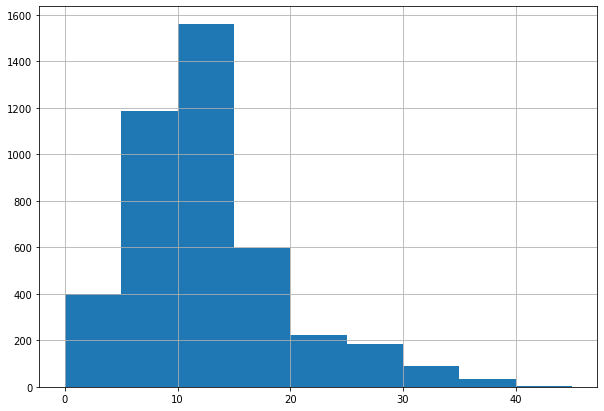

In [ ]:
plt.figure(figsize = (10,7))
num_words = dataset_noduplicate['X'].str.split().map(lambda x: len(x))
num_words.hist(bins=9, range=[0,45])
print("Min    :", num_words.min())
# print(data['text'][num_words[num_words == num_words.min()].index[0]])
print("Max    :",num_words.max())
# print(data['text'][num_words[num_words == num_words.max()].index[0]])
print("Average:", num_words.mean())
print("Sum: ", num_words.sum())

Min    : 2.0
Max    : 13.0
Average: 5.224630762695547


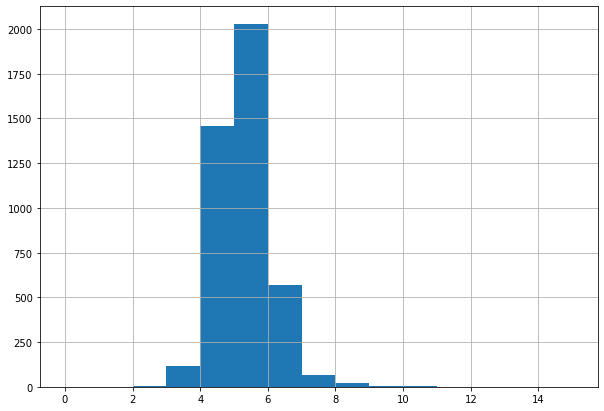

In [ ]:
plt.figure(figsize = (10,7))
avg_length_words = dataset_noduplicate['X'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
avg_length_words.hist(bins=15, range=[0,15])
print("Min    :", avg_length_words.min())
print("Max    :", avg_length_words.max())
print("Average:", avg_length_words.mean())

{2: 3530, 3: 20721, 4: 26781, 5: 28710, 6: 16627, 7: 6781, 8: 3488, 9: 2003, 10: 908, 11: 530, 12: 306, 13: 308, 14: 160, 15: 123, 16: 88, 17: 98, 18: 45, 19: 48, 20: 23, 21: 14, 22: 12, 23: 5, 24: 11, 25: 3, 26: 2, 27: 3, 28: 2, 29: 1, 32: 1, 33: 2, 39: 2, 46: 1, 81: 1}
4.908629578400905


<BarContainer object of 33 artists>

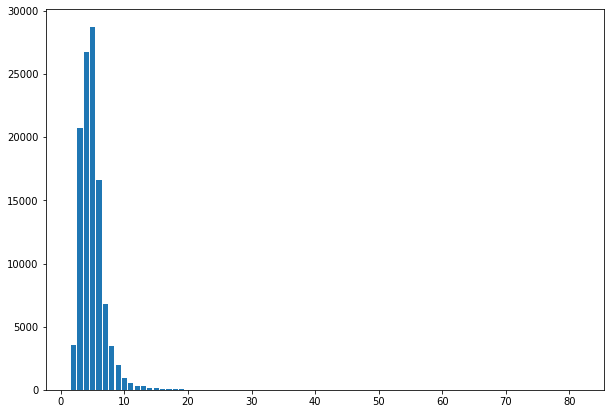

In [ ]:
words_length = {}
for sentence in dataset_noduplicate["X"]:
  for word in sentence.split():
    words_length[len(word)] = words_length.get(len(word),0) + 1

words_length = sorted(words_length.items(), key = lambda x: x[0], reverse = False)
words_length = dict(words_length)
print(words_length)

total = 0
sumtimes = 0
for key, value in words_length.items():
  total = total + value
  sumtimes = sumtimes + key * value
print(sumtimes/total)

plt.figure(figsize = (10,7))
plt.bar(words_length.keys(), words_length.values())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


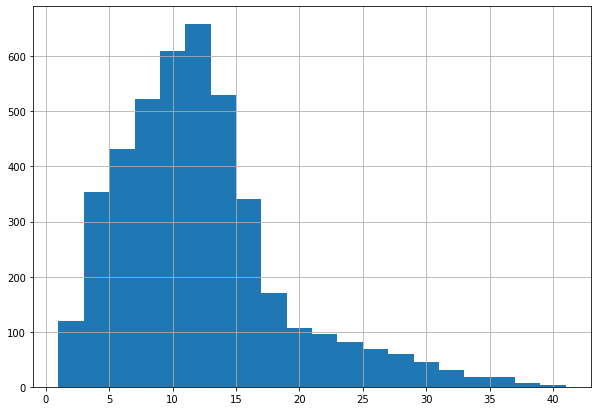

In [ ]:
word_count = []
for sentence in X_noduplicate:
  word_count.append(len(sentence.split()))
dataset_noduplicate['Word count'] = word_count
plt.figure(figsize = (10,7))
dataset_noduplicate["Word count"].hist(bins=20)

In [ ]:
df_negative = dataset_noduplicate.loc[dataset_noduplicate['y'] == 0]
df_neutral = dataset_noduplicate.loc[dataset_noduplicate['y'] == 1]
df_positive = dataset_noduplicate.loc[dataset_noduplicate['y'] == 2]

Negative
Min    : 4
Max    : 245
Average: 68.11514195583597
------------------------------------------
Neutral
Min    : 2
Max    : 235
Average: 68.20160256410256
------------------------------------------
Positive
Min    : 5
Max    : 254
Average: 100.62135922330097
------------------------------------------


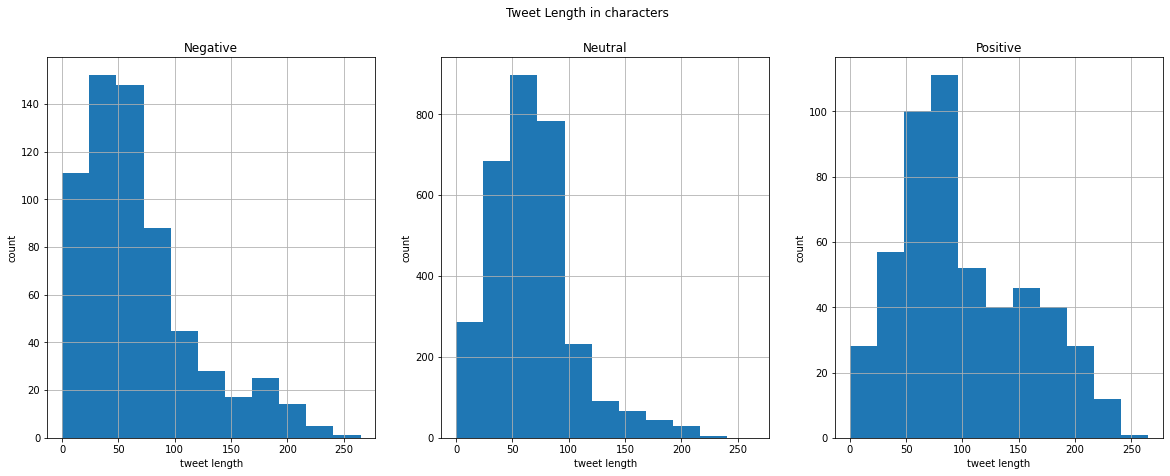

In [ ]:
plt.figure(figsize = (20,7))
plt.suptitle("Tweet Length in characters")
plt.subplot(131)
plt.ylabel('count')
plt.xlabel('tweet length')
plt.title('Negative')
length_negative = df_negative['X'].str.len()
length_negative.hist(bins=11, range=[0,265])
print("Negative")
print("Min    :", length_negative.min())
print("Max    :", length_negative.max())
print("Average:", length_negative.mean())
print("------------------------------------------")

plt.subplot(132)
plt.ylabel('count')
plt.xlabel('tweet length')
plt.title('Neutral')
length_neutral = df_neutral['X'].str.len()
length_neutral.hist(bins=11, range=[0,265])
print("Neutral")
print("Min    :", length_neutral.min())
print("Max    :", length_neutral.max())
print("Average:", length_neutral.mean())
print("------------------------------------------")

plt.subplot(133)
plt.ylabel('count')
plt.xlabel('tweet length')
plt.title('Positive')
length_positive = df_positive['X'].str.len()
length_positive.hist(bins=11, range=[0,265])
print("Positive")
print("Min    :", length_positive.min())
print("Max    :", length_positive.max())
print("Average:", length_positive.mean())
print("------------------------------------------")

NameError: ignored

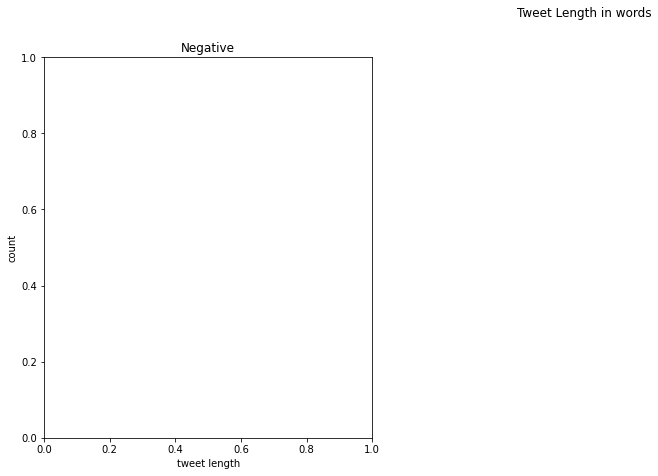

In [ ]:
plt.figure(figsize = (20,7))
plt.suptitle("Tweet Length in words")
plt.subplot(131)
plt.ylabel('count')
plt.xlabel('tweet length')
plt.title('Negative')
num_words_negative = df_negative['X'].str.split().map(lambda x: len(x))
num_words_negative.hist(bins=9, range=[0,45])
print("Negative")
print("Min    :", num_words_negative.min())
print("Max    :",num_words_negative.max())
print("Average:", num_words_negative.mean())
print("Sum: ", num_words_negative.sum())
print("------------------------------------------")

plt.subplot(132)
plt.ylabel('count')
plt.xlabel('tweet length')
plt.title('Neutral')
num_words_neutral = df_neutral['X'].str.split().map(lambda x: len(x))
num_words_neutral.hist(bins=9, range=[0,45])
print("Neutral")
print("Min    :", num_words_neutral.min())
print("Max    :",num_words_neutral.max())
print("Average:", num_words_neutral.mean())
print("Sum: ", num_words_neutral.sum())
print("------------------------------------------")

plt.subplot(133)
plt.ylabel('count')
plt.xlabel('tweet length')
plt.title('Positive')
num_words_positive = df_positive['X'].str.split().map(lambda x: len(x))
num_words_positive.hist(bins=9, range=[0,45])
print("Positive")
print("Min    :", num_words_positive.min())
print("Max    :",num_words_positive.max())
print("Average:", num_words_positive.mean())
print("Sum: ", num_words_positive.sum())
print("------------------------------------------")

Negative
Min    : 3.0
Max    : 9.25
Average: 5.114342232438443
------------------------------------------
neutral
Min    : 2.0
Max    : 10.2
Average: 5.184347122924015
------------------------------------------
positive
Min    : 3.5
Max    : 13.0
Average: 5.604451897200839
------------------------------------------


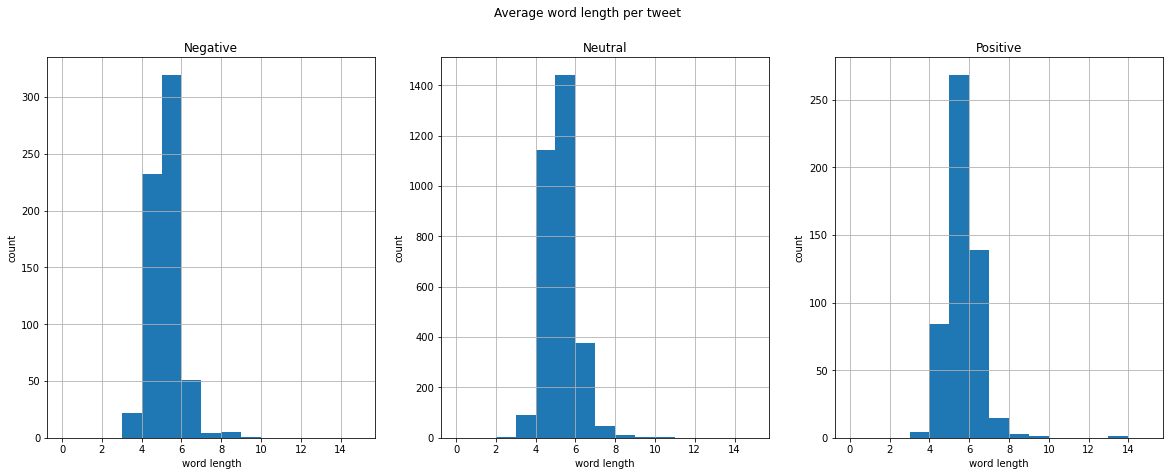

In [ ]:
plt.figure(figsize = (20,7))
plt.suptitle("Average word length per tweet")
plt.subplot(131)
plt.ylabel('count')
plt.xlabel('word length')
plt.title('Negative')
avg_length_words_negative = df_negative['X'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
avg_length_words_negative.hist(bins=15, range=[0,15])
print("Negative")
print("Min    :", avg_length_words_negative.min())
print("Max    :", avg_length_words_negative.max())
print("Average:", avg_length_words_negative.mean())
print("------------------------------------------")

plt.subplot(132)
plt.ylabel('count')
plt.xlabel('word length')
plt.title('Neutral')
avg_length_words_neutral = df_neutral['X'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
avg_length_words_neutral.hist(bins=15, range=[0,15])
print("neutral")
print("Min    :", avg_length_words_neutral.min())
print("Max    :", avg_length_words_neutral.max())
print("Average:", avg_length_words_neutral.mean())
print("------------------------------------------")

plt.subplot(133)
plt.ylabel('count')
plt.xlabel('word length')
plt.title('Positive')
avg_length_words_positive = df_positive['X'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
avg_length_words_positive.hist(bins=15, range=[0,15])
print("positive")
print("Min    :", avg_length_words_positive.min())
print("Max    :", avg_length_words_positive.max())
print("Average:", avg_length_words_positive.mean())
print("------------------------------------------")

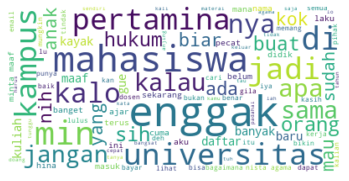

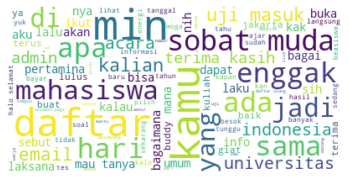

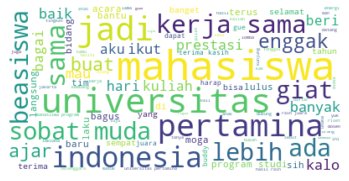

In [ ]:
text = " ".join(tweet for tweet in df_negative["X"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

text = " ".join(tweet for tweet in df_neutral["X"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

text = " ".join(tweet for tweet in df_positive["X"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Initializing Dictionary
d_negative = {}

# counting number of times each word comes up in list of words (in dictionary)
for sentence in df_negative["X"]:
  for word in sentence.split(): 
    d_negative[word] = d_negative.get(word, 0) + 1

print("kata di negative", len(d_negative), "jumlah = ", sum(d_negative.values()))

# Initializing Dictionary
d_neutral = {}

# counting number of times each word comes up in list of words (in dictionary)
for sentence in df_neutral["X"]:
  for word in sentence.split(): 
    d_neutral[word] = d_neutral.get(word, 0) + 1

print("kata di neutral", len(d_neutral), "jumlah = ", sum(d_neutral.values()))

# Initializing Dictionary
d_positive = {}

# counting number of times each word comes up in list of words (in dictionary)
for sentence in df_positive["X"]:
  for word in sentence.split(): 
    d_positive[word] = d_positive.get(word, 0) + 1

print("kata di positive", len(d_positive), "jumlah = ", sum(d_positive.values()))

KeyError: ignored

Kata di negatif dan netral =  400 jumlah =  2695
Kata di negatif dan positive =  56 jumlah =  254
Kata di positive dan netral =  730 jumlah =  7635
Kata di all =  703 jumlah =  32636
Kata hanya di negative =  791 jumlah =  1194
Kata hanya di neutral =  2729 jumlah =  4666
Kata hanya di positive =  620 jumlah =  751


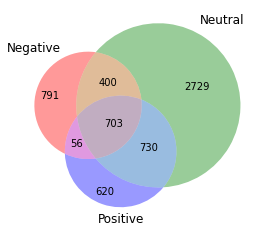

In [ ]:
shared_negative_neutral = {k: d_negative[k] + d_neutral[k] for k in d_negative if k in d_neutral and k not in d_positive}
print("Kata di negatif dan netral = ", len(shared_negative_neutral), "jumlah = ", sum(shared_negative_neutral.values()))

shared_negative_positive = {k: d_negative[k] + d_positive[k] for k in d_negative if k in d_positive and k not in d_neutral}
print("Kata di negatif dan positive = ", len(shared_negative_positive), "jumlah = ", sum(shared_negative_positive.values()))

shared_positive_neutral = {k: d_positive[k] + d_neutral[k] for k in d_positive if k in d_neutral and k not in d_negative}
print("Kata di positive dan netral = ",len(shared_positive_neutral), "jumlah = ", sum(shared_positive_neutral.values()))

shared_all = {k: d_negative[k] + d_neutral[k] + d_positive[k] for k in d_negative if k in d_neutral and k in d_positive}
print("Kata di all = ",len(shared_all), "jumlah = ", sum(shared_all.values()))

only_negative = {k: d_negative[k] for k in d_negative if k not in d_neutral and k not in d_positive}
print("Kata hanya di negative = ",len(only_negative), "jumlah = ", sum(only_negative.values()))

only_neutral = {k: d_neutral[k] for k in d_neutral if k not in d_negative and k not in d_positive}
print("Kata hanya di neutral = ",len(only_neutral), "jumlah = ", sum(only_neutral.values()))

only_positive = {k: d_positive[k] for k in d_positive if k not in d_negative and k not in d_neutral}
print("Kata hanya di positive = ",len(only_positive), "jumlah = ", sum(only_positive.values()))

from matplotlib_venn import venn3
# venn3(subsets = (1, 2, 3, 4, 5, 6, 7), set_labels = ('Set1', 'Set2', 'Set3'))
venn3(subsets = (len(only_negative), len(only_neutral), len(shared_negative_neutral), len(only_positive), len(shared_negative_positive), len(shared_positive_neutral), len(shared_all)), set_labels = ('Negative', 'Neutral', 'Positive'))

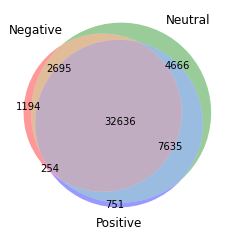

In [ ]:
venn3(subsets = (sum(only_negative.values()), sum(only_neutral.values()), sum(shared_negative_neutral.values()), sum(only_positive.values()), sum(shared_negative_positive.values()), sum(shared_positive_neutral.values()), sum(shared_all.values())), set_labels = ('Negative', 'Neutral', 'Positive'))

In [ ]:
print(type(shared_negative_neutral))

<class 'dict'>


In [ ]:
# word_length_count = []
# sentest = ["this is a test", "this is also a test"]
# for sentence in sentest:
#   word_length = []
#   split_sentence = sentence.split()
#   for word in split_sentence:
#     word_length_count.append(len(word))

# Initializing Dictionary
d = {}

# counting number of times each word comes up in list of words (in dictionary)
for sentence in dataset_noduplicate["X"]:
  for word in sentence.split(): 
    d[word] = d.get(word, 0) + 1


# sorted(d.items(), key = lambda x: x[1], reverse = True)

# Tokennizing Data

In [ ]:
num_words = dataset_noduplicate['X'].str.split().map(lambda x: len(x))
max_length = num_words.max() + 5
X_token = tokennizing(X_noduplicate, X_noduplicate, max_length)

In [ ]:
# assign X and y
X = X_token
y = y_noduplicate

In [ ]:
y_noduplicate.value_counts()

1    3120
0     634
2     515
Name: y, dtype: int64

# Make model

**Make weight class**

since the dataset is imbalance, i decide to use class weight. There are 2 methods to determine the class weight

1st method: using compute class weight from scikit-learn

In [ ]:
# produce array of class weight
class_weights = compute_class_weight('balanced', np.unique(y), y)

# before using it on model, we need to change it to dictionary first
class_weights = dict(enumerate(class_weights))

2nd method: calculate it manually

In [ ]:
# # determine frequency of each class
# data_negative = y_noduplicate[y_noduplicate == 0]
# data_neutral = y_noduplicate[y_noduplicate == 1]
# data_positive = y_noduplicate[y_noduplicate == 2]

# # determine the maximum frequency
# data_majority = np.max([data_negative.shape[0], data_neutral.shape[0], data_positive.shape[0]])

# # determine the weight of each class
# weight_negative = data_negative.shape[0]/data_majority
# weight_neutral = data_neutral.shape[0]/data_majority
# weight_positive = data_positive.shape[0]/data_majority

# class_weights = {0: 1/weight_negative,
#                  1: 1/weight_neutral,
#                  2: 2/weight_positive}

Another way to deal with imbalance dataset is by generate more sample of minority class (oversampling). here i use SMOTE to increase data from class with low frequency (minority), then run it twice since i have 3 classes

In [ ]:
smote = SMOTE(ratio='minority')
X, y = smote.fit_sample(X, y)
X, y = smote.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
class_weights

{0: 1.26602086438152, 1: 0.6732712502476719, 2: 1.3796183516037352}

In [ ]:
unique_elements, counts_elements = np.unique(y, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1    2]
 [ 634 3120  515]]


In [ ]:
# one hot encoding
y = to_categorical(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
def create_graph(history):
  plt.figure(figsize = (15,10))
  plt.subplot(221)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.ylim((0,1.1))
  plt.legend(['training','validation'], loc='best')

  plt.subplot(222)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.ylim((0,6))
  plt.legend(['training','validation'], loc='best')
  plt.show()

In [ ]:
def score_overall(model, batch_size, X_test, y_test):
  y_pred = model.predict_classes(X_test,batch_size = 64)
  df_test = pd.DataFrame({'true': y_test.tolist(), 'pred':y_pred})
  df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))

  f1 = f1_score(df_test.true,df_test.pred,average='weighted')
  acc = accuracy_score(df_test.true,df_test.pred)
  bacc = balanced_accuracy_score(df_test.true,df_test.pred)

  print("Weighted f1 score: ", f1)
  print("Accuracy score: ", acc)
  print("Balanced accuracy score: ", bacc)

  print(classification_report(df_test.true, df_test.pred))

  # print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
  array = confusion_matrix(df_test.true, df_test.pred)
  array_normalized = []
  for row in array:
    row = row/np.sum(row)
    array_normalized.append(row)
  df_cm = pd.DataFrame(array, index=["negative", "neutral", "positive"],
                    columns = ["negative", "neutral", "positive"])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

  return f1, acc, bacc

In [ ]:
def fit_model(X_train, X_test, y_train, y_test, model, opt, learning_rate, batch_size, epochs):
  # Compile model
  if opt == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif opt == 'rms':
    optimizer = RMSprop(learning_rate=learning_rate)
  elif opt == 'nadam':
    optimizer = Nadam(learning_rate=learning_rate)
  elif opt == 'adadelta':
    optimizer = Adadelta(learning_rate=learning_rate)
  elif opt == 'adagrad':
    optimizer = Adagrad(learning_rate=learning_rate)
  elif opt == 'adamax':
    optimizer = Adamax(learning_rate=learning_rate)
  elif opt == 'Ftrl':
    optimizer = Ftrl(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # This callback will stop the training when there is no improvement in
  # the validation loss for five consecutive epochs.
  callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

  # Fit the model
  history = model.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_split=0.2, 
                      verbose=1, # change this to 0 if you don't want to see the log
                      callbacks=[callback],
                      class_weight=class_weights
                      )

  # evaluate the model
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

  return history, model

# **CNN-LSTM**

In [ ]:
def create_cnn_lstm(cnn_layer, lstm_layer, cnn_node, lstm_node, cnn_activation, lstm_activation, dropout_rate):
  model = Sequential()
  model.add(Embedding(np.max(X) + 1, cnn_node, input_length=max_length))
  for i in range(cnn_layer):
    model.add(Conv1D(cnn_node, 5, padding='same', activation=cnn_activation, kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling1D())
  for i in range(lstm_layer - 1):
    model.add(LSTM(lstm_node, dropout=dropout_rate, return_sequences=True))
  model.add(LSTM(lstm_node, dropout=dropout_rate))
  model.add(Dense(3, activation=lstm_activation))
  
  return model

Epoch 1/200
43/43 [==============================] - 17s 388ms/step - loss: 3.2393 - accuracy: 0.5260 - val_loss: 2.9298 - val_accuracy: 0.5886
Epoch 2/200
43/43 [==============================] - 17s 385ms/step - loss: 2.7080 - accuracy: 0.6025 - val_loss: 2.5025 - val_accuracy: 0.4993
Epoch 3/200
43/43 [==============================] - 16s 373ms/step - loss: 2.3171 - accuracy: 0.5271 - val_loss: 2.1475 - val_accuracy: 0.6032
Epoch 4/200
43/43 [==============================] - 16s 381ms/step - loss: 2.0128 - accuracy: 0.5714 - val_loss: 1.8634 - val_accuracy: 0.6266
Epoch 5/200
43/43 [==============================] - 16s 374ms/step - loss: 1.7539 - accuracy: 0.5589 - val_loss: 1.6090 - val_accuracy: 0.6515
Epoch 6/200
43/43 [==============================] - 16s 375ms/step - loss: 1.5455 - accuracy: 0.5889 - val_loss: 1.4447 - val_accuracy: 0.6457
Epoch 7/200
43/43 [==============================] - 16s 368ms/step - loss: 1.3660 - accuracy: 0.6003 - val_loss: 1.3198 - val_accuracy:

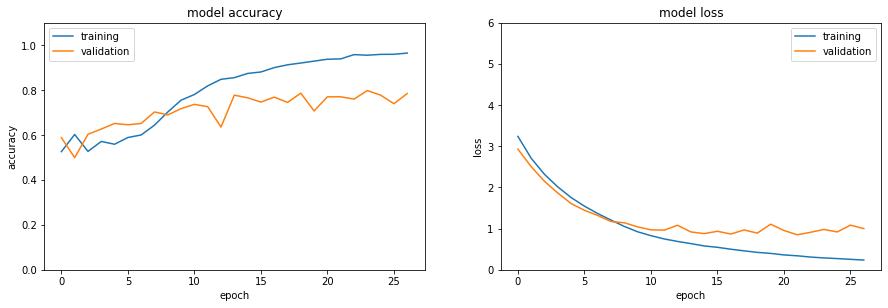

In [ ]:
model_cnn_lstm = create_cnn_lstm(1, 1, 256, 256, 'elu', 'softmax', 0.4)

history_cnn_lstm, model_cnn_lstm = fit_model(X_train, X_test, y_train, y_test, model_cnn_lstm, 'rms', 0.0001, 64, 200)

create_graph(history_cnn_lstm)

**Plotting validation accuracy and loss**

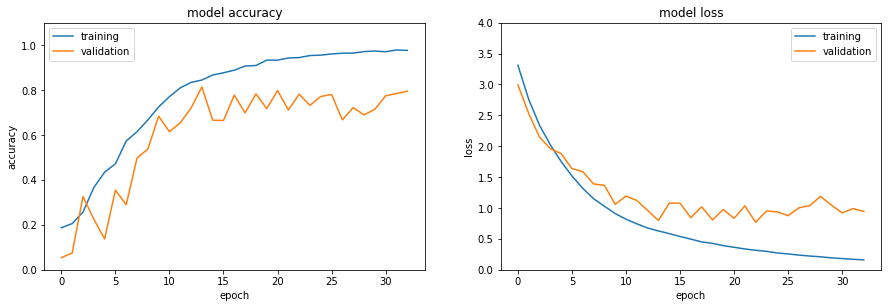

In [ ]:
model.summary()

**Confusion matrix and classification report**

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Weighted f1 score:  0.7240601586219453
Accuracy score:  0.7259953161592506
Balanced accuracy score:  0.6224283600821747
              precision    recall  f1-score   support

           0       0.53      0.77      0.63       150
           1       0.83      0.79      0.81       598
           2       0.46      0.31      0.37       106

    accuracy                           0.73       854
   macro avg       0.61      0.62      0.60       854
weighted avg       0.73      0.73      0.72       854



(0.7240601586219453, 0.7259953161592506, 0.6224283600821747)

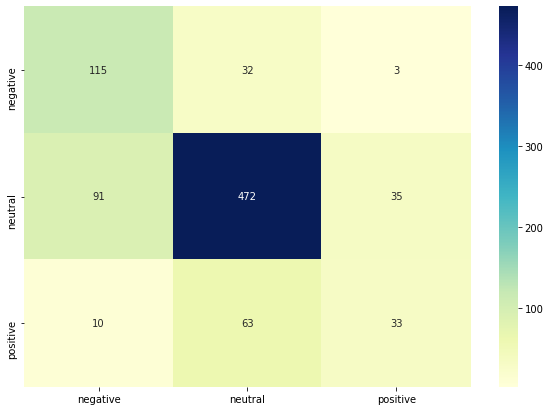

In [ ]:
score_overall(model_cnn_lstm, 64, X_test, y_test)

In [ ]:
now = datetime.now()
dt_string = now.strftime("%b-%d-%Y %H:%M:%S")
saved_folder = '/gdrive/My Drive/Colab Notebooks/Tugas Akhir/saved_model/' + dt_string

In [ ]:
dt_string

'Jun-18-2020 00:44:17'

In [ ]:
model_cnn_lstm.save(saved_folder + 'cnn-lstm.h5')

## 5-Fold Cross Validation

In [ ]:
# assign X and y
# since stratified k fold didn't support one-hot encoded target, the encoding is done on the loop
X2 = X_token
y2 = y_noduplicate

Epoch 1/200
43/43 [==============================] - 18s 415ms/step - loss: 3.3256 - accuracy: 0.1933 - val_loss: 3.0300 - val_accuracy: 0.0498
Epoch 2/200
43/43 [==============================] - 17s 406ms/step - loss: 2.7744 - accuracy: 0.2138 - val_loss: 2.6235 - val_accuracy: 0.0659
Epoch 3/200
43/43 [==============================] - 17s 402ms/step - loss: 2.3737 - accuracy: 0.2650 - val_loss: 2.2242 - val_accuracy: 0.1889
Epoch 4/200
43/43 [==============================] - 17s 404ms/step - loss: 2.0617 - accuracy: 0.3580 - val_loss: 1.9897 - val_accuracy: 0.2518
Epoch 5/200
43/43 [==============================] - 18s 421ms/step - loss: 1.7972 - accuracy: 0.4217 - val_loss: 1.7723 - val_accuracy: 0.3909
Epoch 6/200
43/43 [==============================] - 18s 411ms/step - loss: 1.5735 - accuracy: 0.5117 - val_loss: 1.5944 - val_accuracy: 0.4905
Epoch 7/200
43/43 [==============================] - 18s 410ms/step - loss: 1.3647 - accuracy: 0.5911 - val_loss: 1.7243 - val_accuracy:

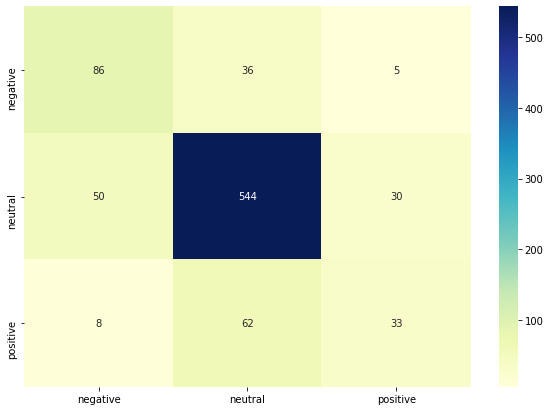

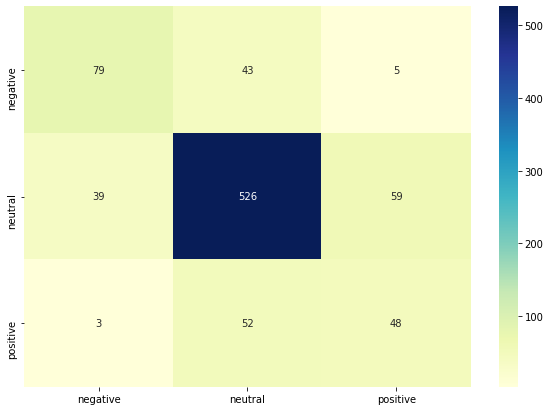

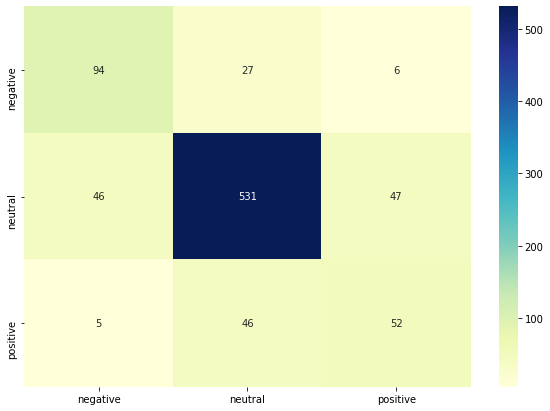

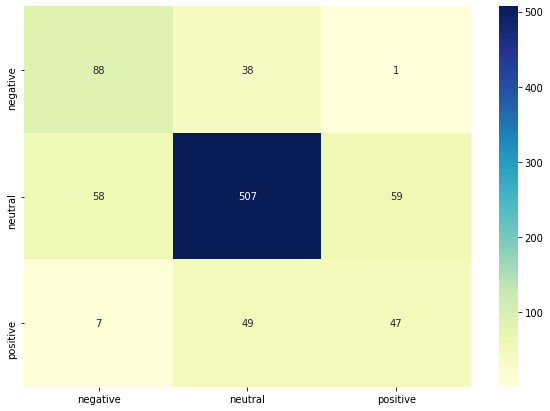

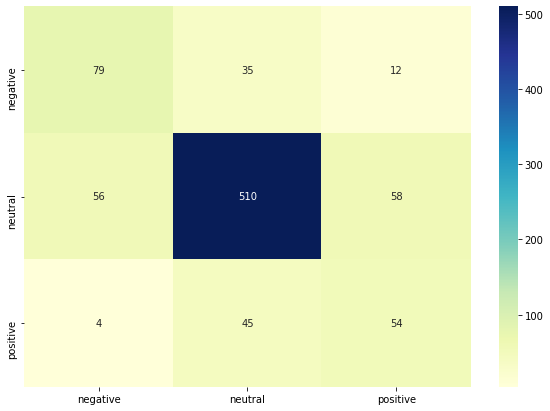

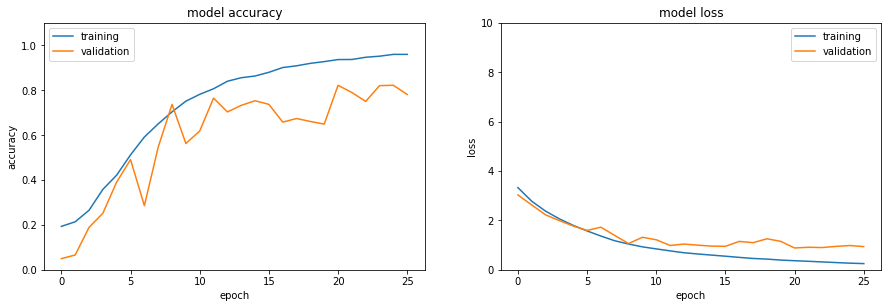

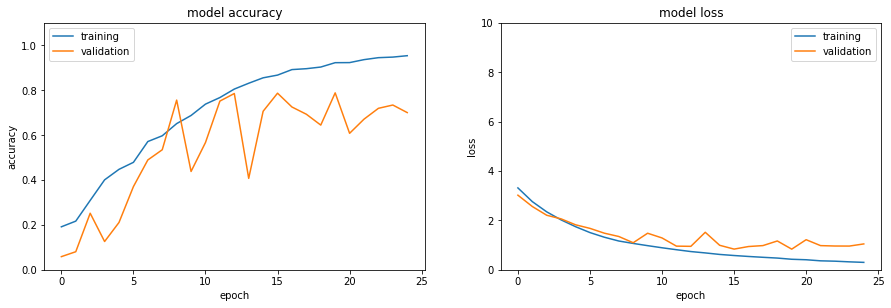

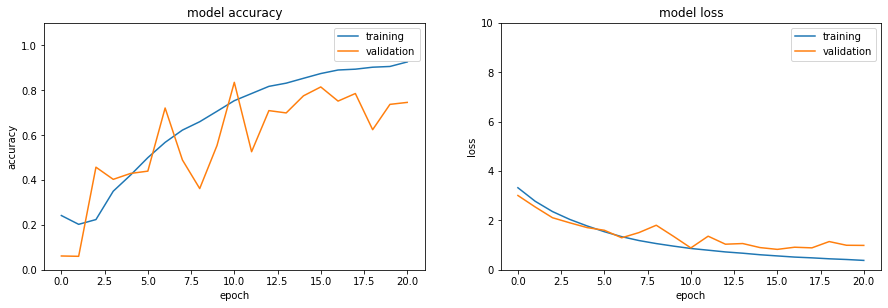

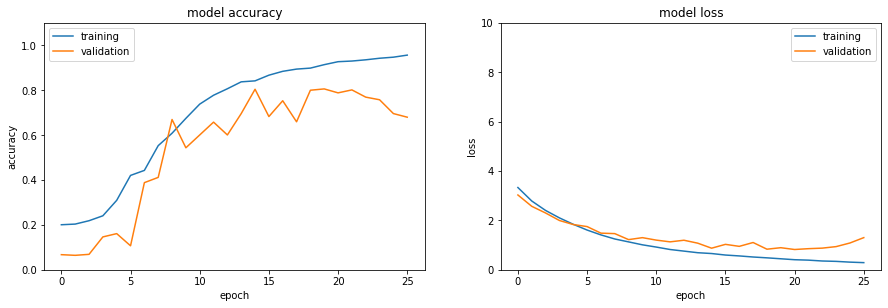

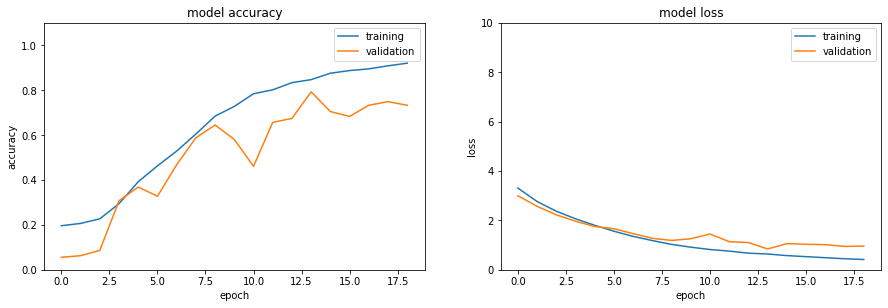

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

seed = 42
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
weightedf1Scores = []
balancedAccScores = []
accScores = []

history_cnn_lstm_5fold = []

for train, test in kfold.split(X2, y2):
  # Make the model 
  model_cnn_lstm_5fold = create_cnn_lstm(1, 1, 256, 256, 'elu', 'softmax', 0.4)

  y2_categorical = to_categorical(y2)

  hist, model_cnn_lstm_5fold = fit_model(X2[train], X2[test], y2_categorical[train], y2_categorical[test], model_cnn_lstm_5fold, 'rms', 0.0001, 64, 200)

  history_cnn_lstm_5fold.append(hist)

  f1, acc, bacc = score_overall(model_cnn_lstm_5fold, 64, X2[test], y2_categorical[test])
  weightedf1Scores.append(f1)
  
  accScores.append(acc)

  balancedAccScores.append(bacc)

print("Weighted f1        : ", np.mean(weightedf1Scores))
print("Accuracy           : ", np.mean(accScores))
print("Balanced Accuracy  : ", np.mean(balancedAccScores))
print("-----------------------------------------------------------------------------------------------------------------------------")

for history in history_cnn_lstm_5fold:
  create_graph(history)

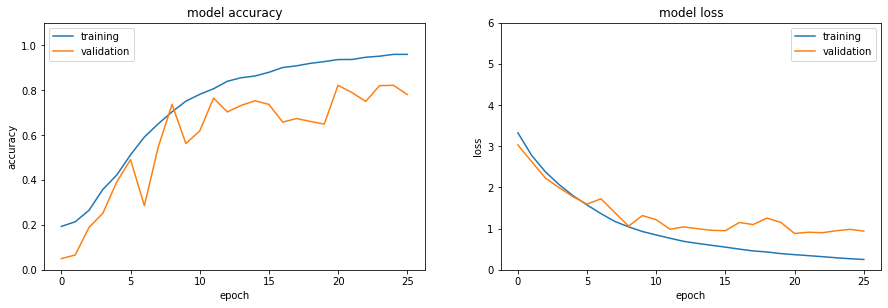

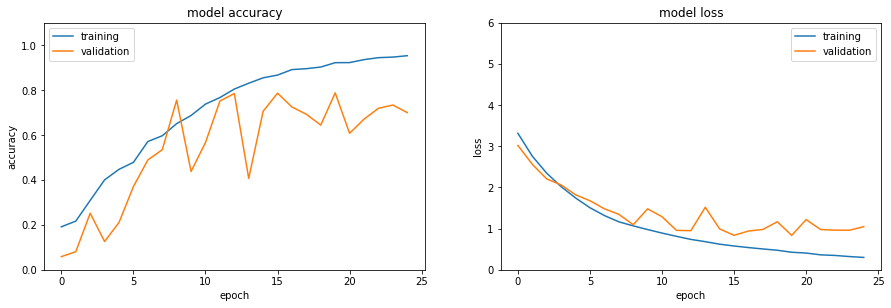

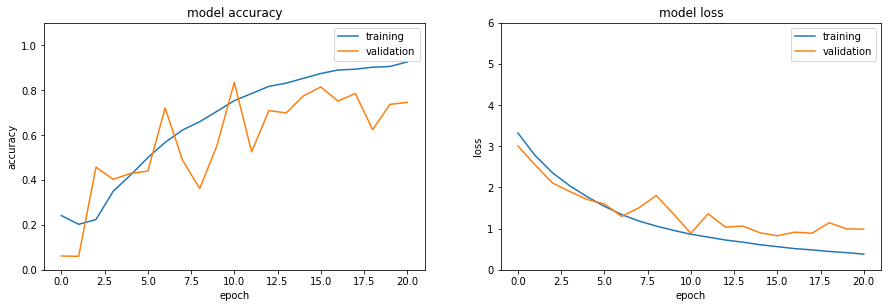

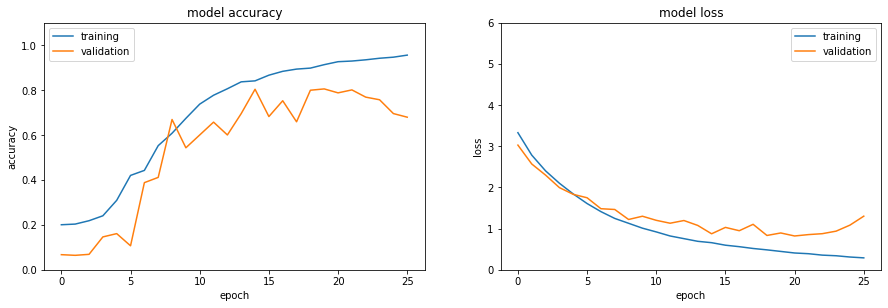

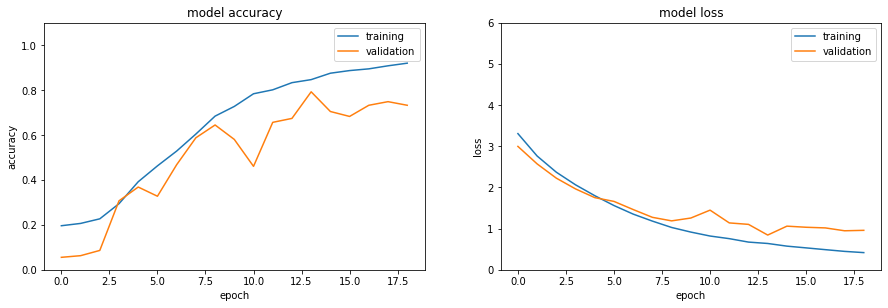

In [ ]:
for history in history_cnn_lstm_5fold:
  create_graph(history)

In [ ]:
model.save(saved_folder + 'cnn-lstm-5fold.h5')

# **CNN**

In [ ]:
def create_cnn(cnn_layer, cnn_node, cnn_activation, dense_activation):
  model = Sequential()
  model.add(Embedding(np.max(X) + 1, cnn_node, input_length=max_length))
  for i in range(cnn_layer):
    model.add(Conv1D(cnn_node, 5, padding='same', activation=cnn_activation, kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(3, activation=dense_activation))
  
  return model

In [ ]:
model_cnn = create_cnn(2, 256, 'elu', 'softmax')

history_cnn, model_cnn = fit_model(X_train, X_test, y_train, y_test, model_cnn, 'rms', 0.0001, 64, 200)

Epoch 1/200
43/43 [==============================] - 13s 307ms/step - loss: 5.4850 - accuracy: 0.5099 - val_loss: 4.8661 - val_accuracy: 0.7189
Epoch 2/200
43/43 [==============================] - 13s 301ms/step - loss: 4.4751 - accuracy: 0.5150 - val_loss: 3.9554 - val_accuracy: 0.7174
Epoch 3/200
43/43 [==============================] - 13s 298ms/step - loss: 3.6768 - accuracy: 0.5403 - val_loss: 3.2826 - val_accuracy: 0.6457
Epoch 4/200
43/43 [==============================] - 13s 302ms/step - loss: 3.0251 - accuracy: 0.5421 - val_loss: 2.7289 - val_accuracy: 0.5476
Epoch 5/200
43/43 [==============================] - 13s 300ms/step - loss: 2.4972 - accuracy: 0.5183 - val_loss: 2.3040 - val_accuracy: 0.4436
Epoch 6/200
43/43 [==============================] - 13s 297ms/step - loss: 2.0707 - accuracy: 0.5022 - val_loss: 1.8558 - val_accuracy: 0.6296
Epoch 7/200
43/43 [==============================] - 13s 301ms/step - loss: 1.7317 - accuracy: 0.5589 - val_loss: 1.6258 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 43, 180)           1085400   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 39, 180)           162180    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 180)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 543       
Total params: 1,248,123
Trainable params: 1,248,123
Non-trainable params: 0
_________________________________________________________________


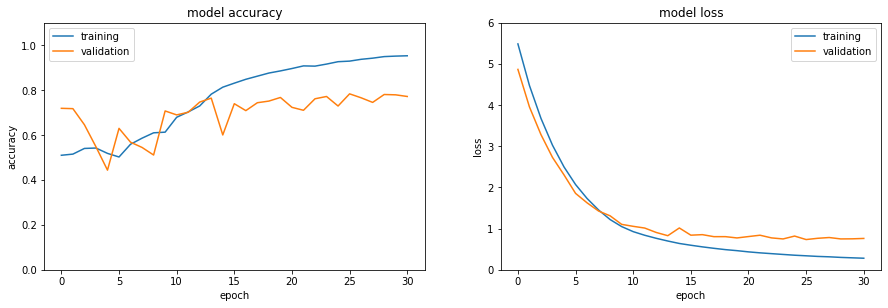

In [ ]:
create_graph(history_cnn)

In [ ]:
model_cnn.save(saved_folder + 'cnn.h5')

In [ ]:
# assign X and y
# since stratified k fold didn't support one-hot encoded target, the encoding is done on the loop
X2 = X_token
y2 = y_noduplicate

Epoch 1/200
43/43 [==============================] - 13s 305ms/step - loss: 5.5689 - accuracy: 0.2584 - val_loss: 5.0379 - val_accuracy: 0.0630
Epoch 2/200
43/43 [==============================] - 13s 305ms/step - loss: 4.5720 - accuracy: 0.2467 - val_loss: 4.1327 - val_accuracy: 0.2299
Epoch 3/200
43/43 [==============================] - 13s 310ms/step - loss: 3.7750 - accuracy: 0.3181 - val_loss: 3.4181 - val_accuracy: 0.3045
Epoch 4/200
43/43 [==============================] - 13s 295ms/step - loss: 3.1174 - accuracy: 0.3884 - val_loss: 2.8881 - val_accuracy: 0.2840
Epoch 5/200
43/43 [==============================] - 14s 319ms/step - loss: 2.5735 - accuracy: 0.4100 - val_loss: 2.4621 - val_accuracy: 0.3016
Epoch 6/200
43/43 [==============================] - 15s 358ms/step - loss: 2.1312 - accuracy: 0.4473 - val_loss: 2.0273 - val_accuracy: 0.3807
Epoch 7/200
43/43 [==============================] - 15s 344ms/step - loss: 1.7594 - accuracy: 0.4894 - val_loss: 1.7116 - val_accuracy:

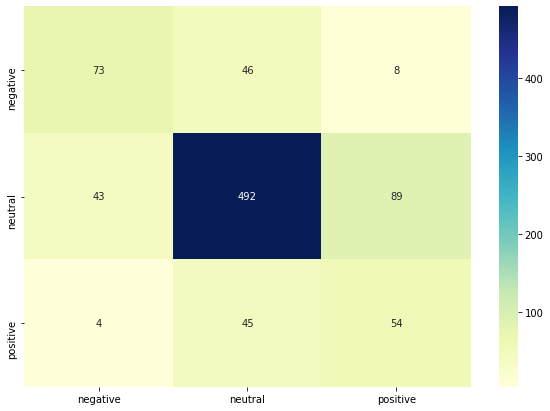

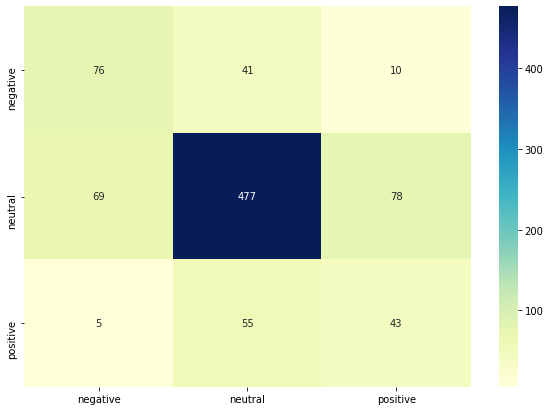

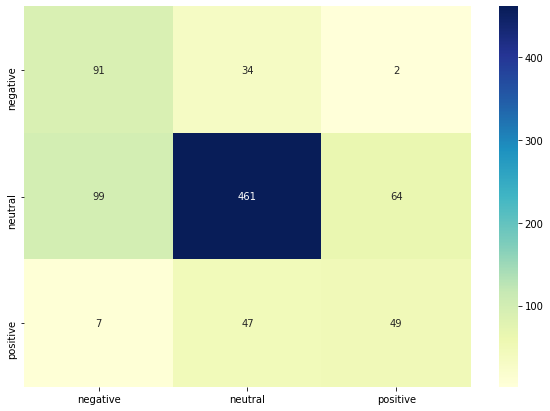

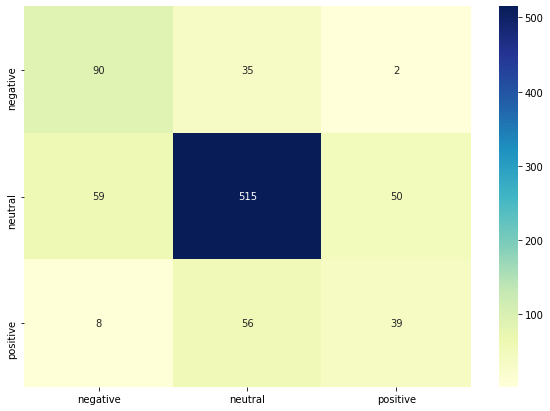

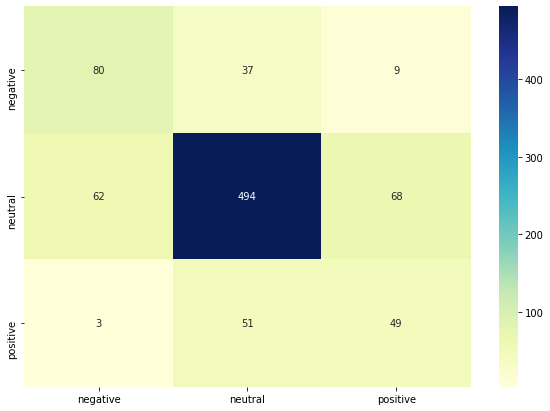

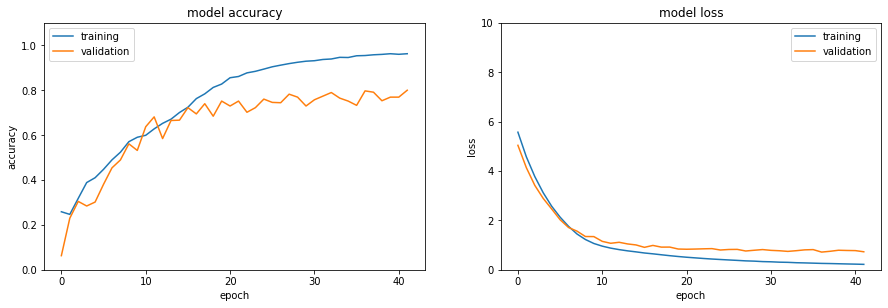

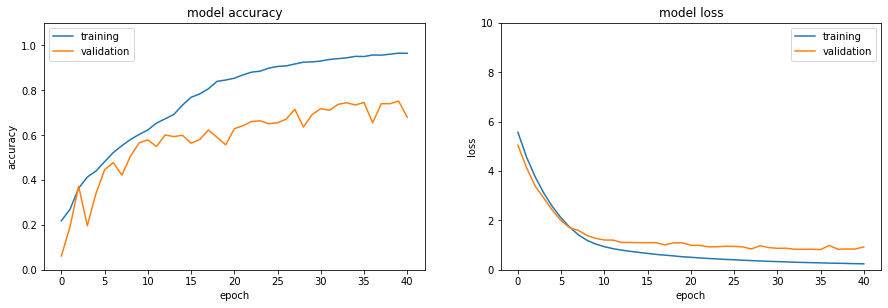

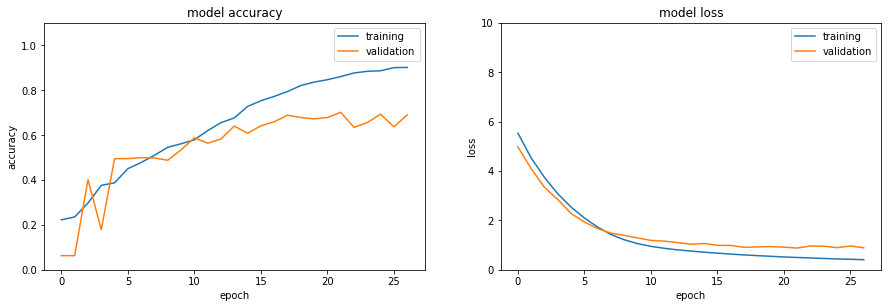

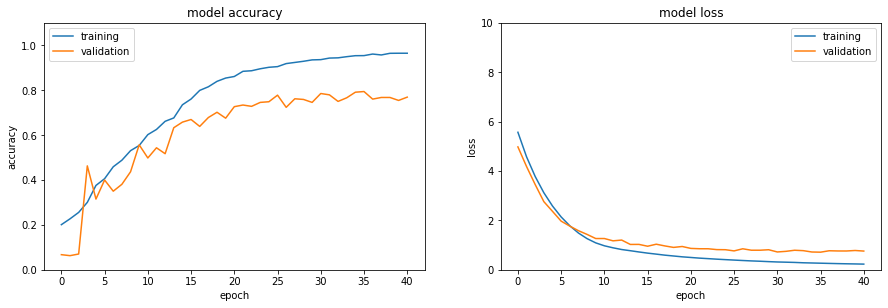

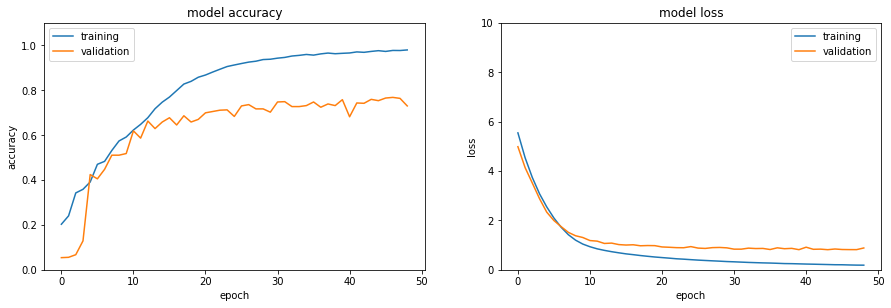

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

seed = 42
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
weightedf1Scores = []
balancedAccScores = []
accScores = []

history_cnn_5fold = []

for train, test in kfold.split(X2, y2):
  # Make the model 
  model_cnn_5fold = create_cnn(2, 256, 'elu', 'softmax')

  y2_categorical = to_categorical(y2)

  hist, model_cnn_5fold = fit_model(X2[train], X2[test], y2_categorical[train], y2_categorical[test], model_cnn_5fold, 'rms', 0.0001, 64, 200)

  history_cnn_5fold.append(hist)

  f1, acc, bacc = score_overall(model_cnn_5fold, 64, X2[test], y2_categorical[test])
  weightedf1Scores.append(f1)
  
  accScores.append(acc)

  balancedAccScores.append(bacc)

print("Weighted f1        : ", np.mean(weightedf1Scores))
print("Accuracy           : ", np.mean(accScores))
print("Balanced Accuracy  : ", np.mean(balancedAccScores))
print("-----------------------------------------------------------------------------------------------------------------------------")

for history in history_cnn_5fold:
  create_graph(history)

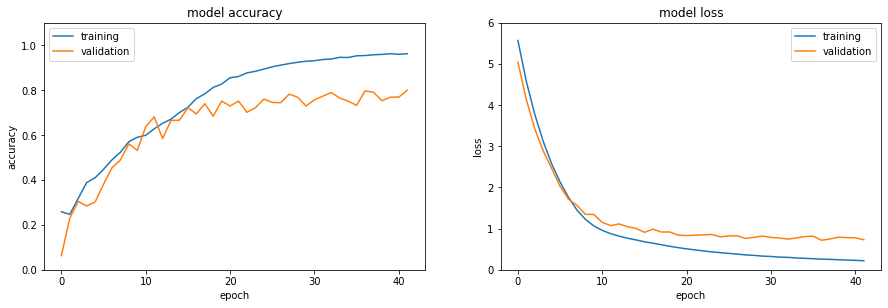

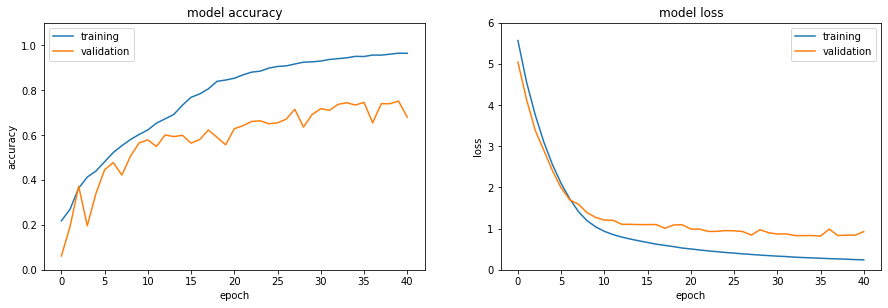

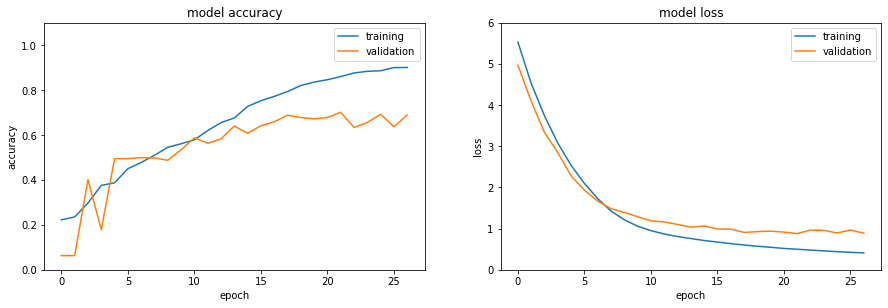

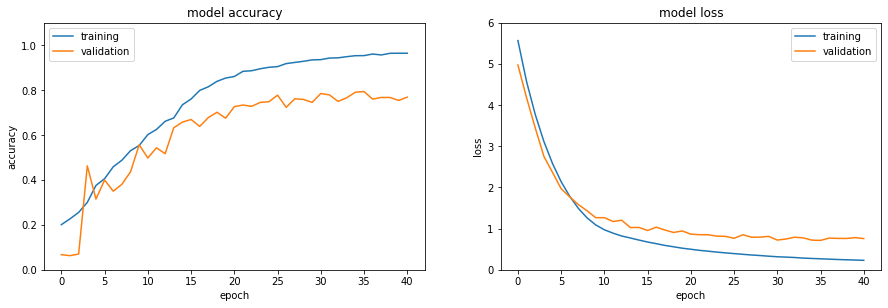

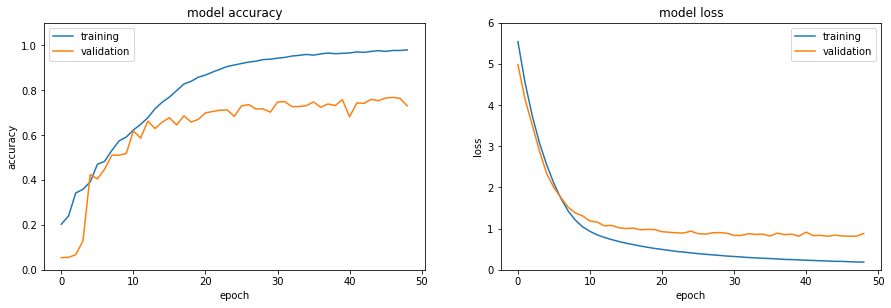

In [ ]:
for history in history_cnn_5fold:
  create_graph(history)

In [ ]:
model.save(saved_folder + 'cnn-5fold.h5')

# **LSTM**

In [ ]:
def create_lstm(lstm_layer, lstm_node, dense_activation, dropout_rate):
  model = Sequential()
  model.add(Embedding(np.max(X) + 1, lstm_node, input_length=max_length))
  for i in range(lstm_layer - 1):
    model.add(LSTM(lstm_node, dropout=dropout_rate, return_sequences=True))
  model.add(LSTM(lstm_node, dropout=dropout_rate))
  model.add(Dense(3, activation=dense_activation))
  
  return model

In [ ]:
model_lstm = create_lstm(2, 256, 'softmax', 0)

history_lstm, model_lstm = fit_model(X_train, X_test, y_train, y_test, model_lstm, 'rms', 0.0001, 64, 200)

Epoch 1/200
43/43 [==============================] - 49s 1s/step - loss: 1.0816 - accuracy: 0.6076 - val_loss: 1.0060 - val_accuracy: 0.7291
Epoch 2/200
43/43 [==============================] - 48s 1s/step - loss: 1.0412 - accuracy: 0.5977 - val_loss: 1.0118 - val_accuracy: 0.5227
Epoch 3/200
43/43 [==============================] - 47s 1s/step - loss: 0.9920 - accuracy: 0.5286 - val_loss: 0.9874 - val_accuracy: 0.5329
Epoch 4/200
43/43 [==============================] - 48s 1s/step - loss: 0.9386 - accuracy: 0.5483 - val_loss: 0.9563 - val_accuracy: 0.5417
Epoch 5/200
43/43 [==============================] - 48s 1s/step - loss: 0.8578 - accuracy: 0.5908 - val_loss: 0.8263 - val_accuracy: 0.6955
Epoch 6/200
43/43 [==============================] - 46s 1s/step - loss: 0.7525 - accuracy: 0.6471 - val_loss: 0.8010 - val_accuracy: 0.6149
Epoch 7/200
43/43 [==============================] - 48s 1s/step - loss: 0.6549 - accuracy: 0.6900 - val_loss: 0.8450 - val_accuracy: 0.5798
Epoch 8/200
4

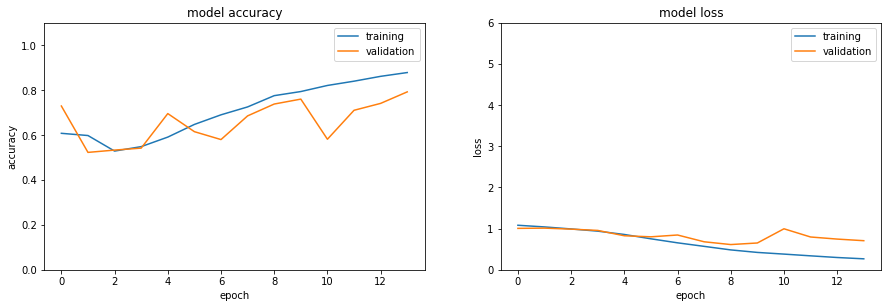

In [ ]:
create_graph(history_lstm)

In [ ]:
model_lstm.save(saved_folder + 'lstm.h5')

Epoch 1/200
43/43 [==============================] - 29s 681ms/step - loss: 1.1582 - accuracy: 0.2046 - val_loss: 1.1533 - val_accuracy: 0.0527
Epoch 2/200
43/43 [==============================] - 28s 661ms/step - loss: 1.1112 - accuracy: 0.2306 - val_loss: 1.0732 - val_accuracy: 0.2328
Epoch 3/200
43/43 [==============================] - 29s 669ms/step - loss: 1.0677 - accuracy: 0.3316 - val_loss: 1.1255 - val_accuracy: 0.1713
Epoch 4/200
43/43 [==============================] - 29s 664ms/step - loss: 1.0171 - accuracy: 0.3821 - val_loss: 1.0165 - val_accuracy: 0.4363
Epoch 5/200
43/43 [==============================] - 29s 671ms/step - loss: 0.9627 - accuracy: 0.4645 - val_loss: 1.0964 - val_accuracy: 0.3470
Epoch 6/200
43/43 [==============================] - 29s 672ms/step - loss: 0.8720 - accuracy: 0.5414 - val_loss: 1.0373 - val_accuracy: 0.4539
Epoch 7/200
43/43 [==============================] - 29s 666ms/step - loss: 0.7925 - accuracy: 0.5882 - val_loss: 0.8745 - val_accuracy:

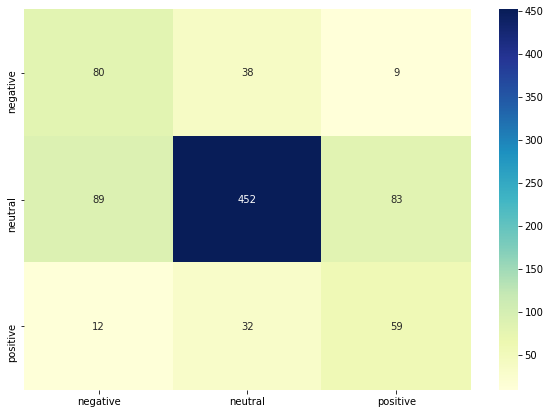

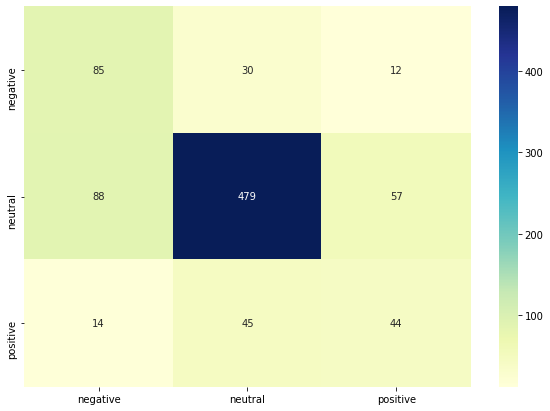

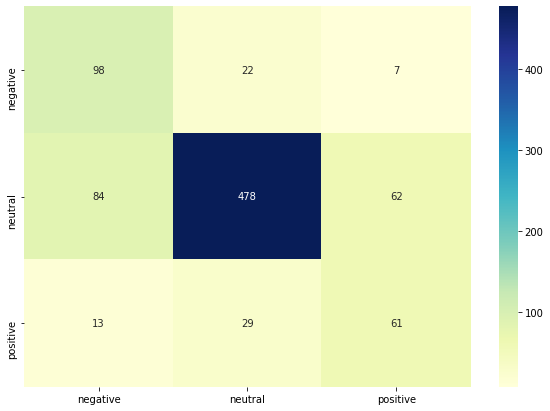

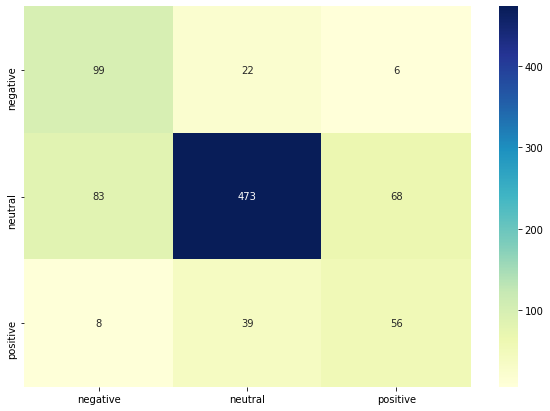

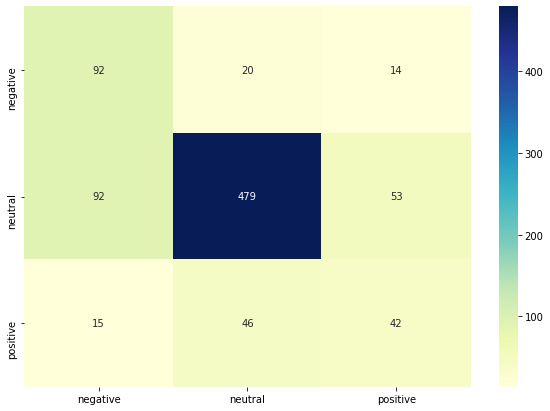

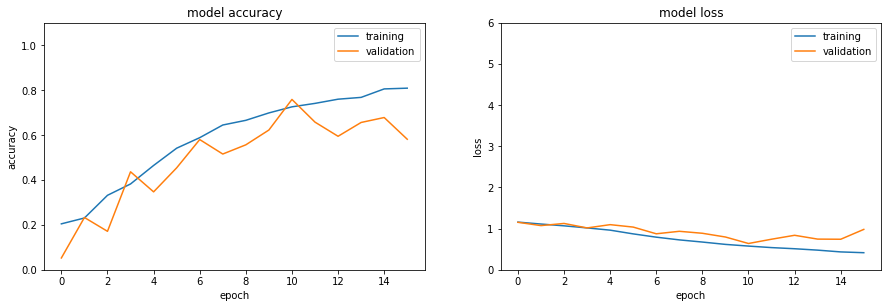

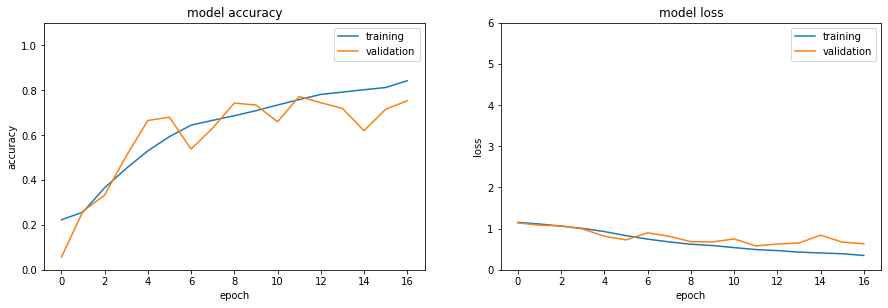

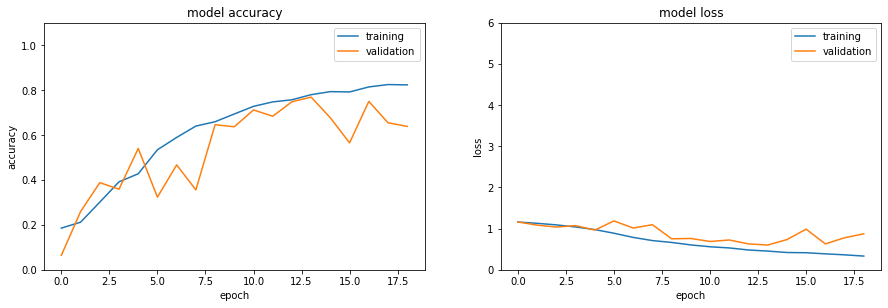

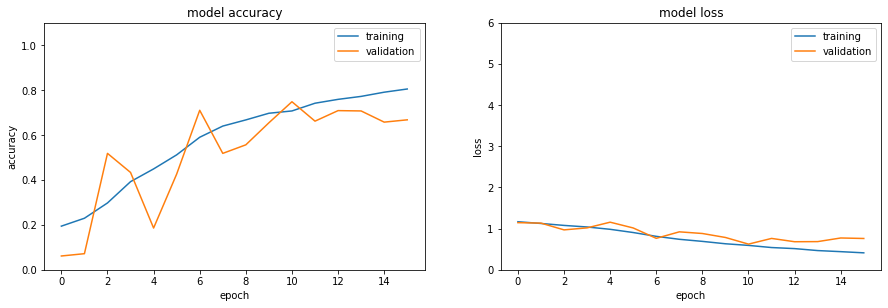

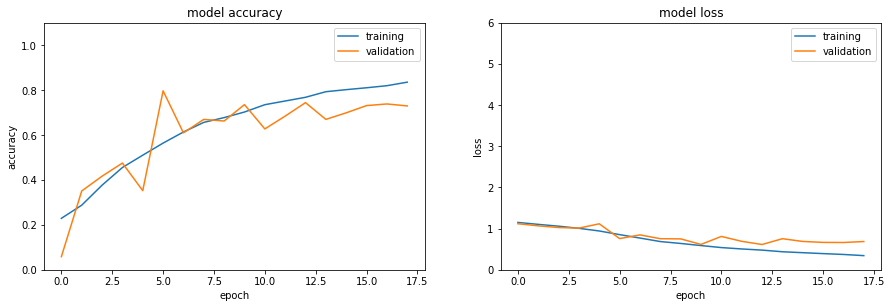

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

# assign X and y
# since stratified k fold didn't support one-hot encoded target, the encoding is done on the loop
X2 = X_token
y2 = y_noduplicate

seed = 42
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
weightedf1Scores = []
balancedAccScores = []
accScores = []

history_lstm_5fold = []

for train, test in kfold.split(X2, y2):
  # Make the model 
  model_lstm_5fold = create_lstm(2, 256, 'softmax', 0.4)

  y2_categorical = to_categorical(y2)

  hist, model_lstm_5fold = fit_model(X2[train], X2[test], y2_categorical[train], y2_categorical[test], model_lstm_5fold, 'rms', 0.0001, 64, 200)

  history_lstm_5fold.append(hist)

  f1, acc, bacc = score_overall(model_lstm_5fold, 64, X2[test], y2_categorical[test])
  weightedf1Scores.append(f1)
  
  accScores.append(acc)

  balancedAccScores.append(bacc)

print("Weighted f1        : ", np.mean(weightedf1Scores))
print("Accuracy           : ", np.mean(accScores))
print("Balanced Accuracy  : ", np.mean(balancedAccScores))
print("-----------------------------------------------------------------------------------------------------------------------------")

for history in history_lstm_5fold:
  create_graph(history)

In [ ]:
model.save(saved_folder + 'lstm.h5')

In [ ]:
def create_lstm_tuning(lstm_layer, lstm_node, dense_activation, dropout_rate, optimizer):
  model = Sequential()
  model.add(Embedding(np.max(X) + 1, lstm_node, input_length=max_length))
  for i in range(lstm_layer):
    model.add(LSTM(lstm_node, dropout=dropout_rate, return_sequences=True))
  model.add(LSTM(lstm_node, dropout=dropout_rate))
  model.add(Dense(3, activation=dense_activation))
  model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

# create model
model_lstm_tuning = KerasClassifier(build_fn=create_lstm_tuning, epochs=30, batch_size=64, verbose=0)
# define the grid search parameters
lstm_layer = [1,2]
lstm_node = [64, 128, 256, 512]
dropout_rate=[0.1, 0.2, 0.3, 0.4, 0.5]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(lstm_layer=lstm_layer, lstm_node=lstm_node, dense_activation=activation, dropout_rate=dropout_rate, optimizer=optimizer)
grid = RandomizedSearchCV(estimator=model_lstm_tuning, param_distributions=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: ignored

In [ ]:
model.save(saved_folder + 'lstm-5fold.h5')